In [32]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as smf

In [33]:
consume_data = pd.read_csv('/home/julian/Cursos/Ironhack/Career/reto_data/consume_data.csv')

### EDA

In [3]:
consume_data.shape

(376, 11)

In [4]:
consume_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   consume_id    376 non-null    int64  
 1   distance      376 non-null    float64
 2   consume       376 non-null    float64
 3   speed         376 non-null    int64  
 4   temp_inside   376 non-null    float64
 5   temp_outside  376 non-null    int64  
 6   gas_type      376 non-null    object 
 7   AC            376 non-null    int64  
 8   rain          376 non-null    int64  
 9   sun           376 non-null    int64  
 10  snow          376 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 32.4+ KB


In [5]:
consume_data.isna().value_counts()

consume_id  distance  consume  speed  temp_inside  temp_outside  gas_type  AC     rain   sun    snow 
False       False     False    False  False        False         False     False  False  False  False    376
dtype: int64

In [6]:
consume_data.gas_type.value_counts()

SP98    219
E10     157
Name: gas_type, dtype: int64

- We can see that all variabels are numerical, except for gas_type, which we'll transform into a dummy variable. On the other hand, we don'thave null values.
- We'll also drop consume_id column as is an index column.

In [34]:
consume_data = pd.get_dummies(consume_data, columns=['gas_type'], drop_first=True)

In [35]:
consume_data.drop(columns=['consume_id'], inplace=True)

In [5]:
consume_data.head(3)

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0,0


In [10]:
consume = {'Minimum': consume_data.consume.min(),
          'Maximum': consume_data.consume.max(),
          'Mean': consume_data.consume.mean(),
          'Median': consume_data.consume.median(),
          'Mode': consume_data.consume.mode()}

In [11]:
consume_descr = pd.DataFrame(consume) 
consume_descr = consume_descr.rename(index={0:'Consume'})
consume_descr

,Minimum,Maximum,Mean,Median,Mode
Consume,3.3,12.2,4.925266,4.7,4.5


<AxesSubplot:xlabel='consume', ylabel='Count'>

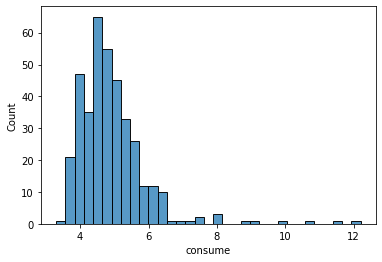

In [12]:
sns.histplot(x='consume', data=consume_data)

<AxesSubplot:xlabel='consume'>

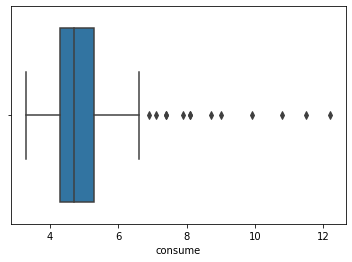

In [11]:
sns.boxplot(x=consume_data.consume)

- We can observe that we have some outliers in the consume column

In [13]:
corr_matrix = consume_data.corr()

In [14]:
corr_matrix

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98
distance,1.000000,-0.131379,0.565505,0.075305,0.086774,0.019030,-0.030784,0.078627,-0.034428,-0.047877
consume,-0.131379,1.000000,-0.234537,-0.161991,-0.318758,0.089472,0.251756,-0.169173,0.072308,-0.020928
speed,0.565505,-0.234537,1.000000,0.059725,0.019327,-0.024485,-0.004173,0.077181,0.032500,-0.099495
temp_inside,0.075305,-0.161991,0.059725,1.000000,0.361308,0.313197,-0.038269,0.246120,0.097156,0.010340
temp_outside,0.086774,-0.318758,0.019327,0.361308,1.000000,0.180096,-0.184763,0.349988,-0.162948,0.156990
AC,0.019030,0.089472,-0.024485,0.313197,0.180096,1.000000,0.242197,0.085928,0.063170,0.096943
rain,-0.030784,0.251756,-0.004173,-0.038269,-0.184763,0.242197,1.000000,-0.111916,0.277739,0.052789
sun,0.078627,-0.169173,0.077181,0.246120,0.349988,0.085928,-0.111916,1.000000,-0.031083,0.038120
snow,-0.034428,0.072308,0.032500,0.097156,-0.162948,0.063170,0.277739,-0.031083,1.000000,0.035231
gas_type_SP98,-0.047877,-0.020928,-0.099495,0.010340,0.156990,0.096943,0.052789,0.038120,0.035231,1.000000


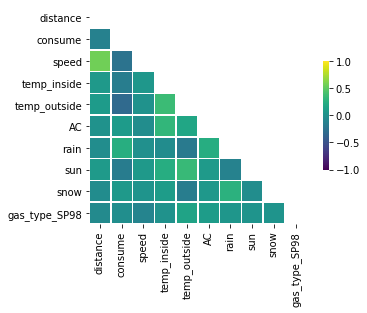

In [15]:
mascara = np.triu(np.ones_like(corr_matrix, dtype=bool))
color_map = sns.diverging_palette(0, 10, as_cmap=True) 

sns.heatmap(corr_matrix, 
            mask=mascara,
            cmap="viridis",
            vmax=1,
            vmin=-1,
            square=True, 
            linewidth=.5, 
            cbar_kws={"shrink": .5} 
);

- We can see through the correlations heatmap that `consume` is mostly correlated with `temp_outside` (negatively), `rain` (positively), `speed` (negatively), `sun` (negatively), and `temp_inside` (negatively).
- We can also observe that `speed` and `distance` are correlated, and `temp_inside` wit `AC`. Both are not surprise.

<AxesSubplot:xlabel='temp_outside', ylabel='consume'>

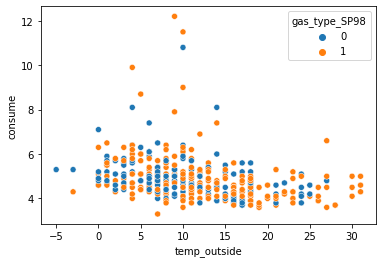

In [9]:
sns.scatterplot(x=consume_data.temp_outside, y=consume_data.consume, hue=consume_data.gas_type_SP98)

<AxesSubplot:xlabel='temp_inside', ylabel='consume'>

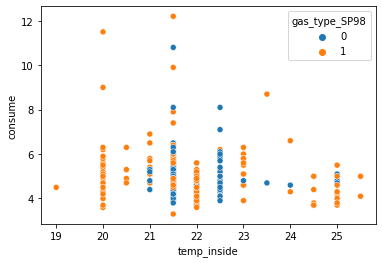

In [53]:
sns.scatterplot(x=consume_data.temp_inside, y=consume_data.consume, hue=consume_data.gas_type_SP98)

#### CONSUME VS GAS_TYPE

In [16]:
gtype_gr = consume_data.groupby('gas_type_SP98').agg({'consume': 'mean'})
gtype_gr

,consume
gas_type_SP98,
0,4.950955
1,4.906849


#### CONSUME VS AC

In [18]:
ac_group = consume_data.groupby('AC').agg({'consume': 'mean'})
ac_group

,consume
AC,
0,4.897391
1,5.235484


#### CONSUME VS RAIN

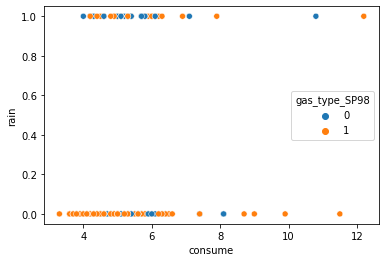

In [57]:
sns.scatterplot(y=consume_data.rain, x=consume_data.consume, hue=consume_data.gas_type_SP98);

In [19]:
rain_gr = consume_data.groupby('rain').agg({'consume': 'mean'})
rain_gr

,consume
rain,
0,4.827576
1,5.626087


### REGRESSION ANALYSIS

In [19]:
consume_data.head(3)

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98
0,28.0,5.0,26,21.5,12,0,0,0,0,0
1,12.0,4.2,30,21.5,13,0,0,0,0,0
2,11.2,5.5,38,21.5,15,0,0,0,0,0


In [39]:
linear_model = smf.ols("consume ~ distance + speed + temp_inside + temp_outside + AC + rain + sun + snow + gas_type_SP98", data=consume_data).fit()

In [40]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                consume   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.188
Method:                 Least Squares   F-statistic:                     10.68
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           9.76e-15
Time:                        12:49:05   Log-Likelihood:                -504.20
No. Observations:                 376   AIC:                             1028.
Df Residuals:                     366   BIC:                             1068.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         7.7409      1.186      6.526      0.000       5.408      10.073
distance          0.0018      0.003      0.683      0.495      -0.003       0.007
speed            -0.0184      0.004     -4.259      0.000      -0.027      -0.010
temp_inside      -0.0776      0.055     -1.414      0.158      -0.185       0.030
temp_outside     -0.0394      0.008     -4.873      0.000      -0.055      -0.023
AC                0.4471      0.195      2.298      0.022       0.065       0.830
rain              0.5432      0.162      3.344      0.001       0.224       0.863
sun              -0.1210      0.190     -0.636      0.525      -0.495       0.253
snow             -0.1020      0.503     -0.203      0.839      -1.091       0.887
gas_type_SP98    -0.0408      0.101     -0.406      0.685      -0.239       0.157
==============================================================================
Omnibus:                      248.482   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2919.818
Skew:                           2.651   Prob(JB):                         0.00
Kurtosis:                      15.580   Cond. No.                     1.37e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.37e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
consume_data['log_consume'] = np.log(consume_data.consume)

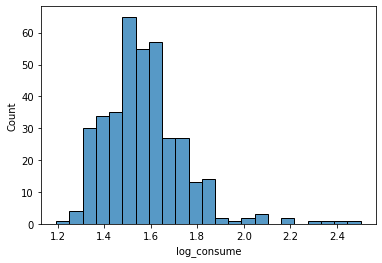

In [58]:
sns.histplot(consume_data.log_consume);

In [59]:
scaler = StandardScaler()

In [60]:
consume_data_scaled=pd.DataFrame(scaler.fit_transform(consume_data), columns=consume_data.columns)
consume_data_scaled.head()

,distance,consume,speed,temp_inside,temp_outside,AC,rain,sun,snow,gas_type_SP98,log_consume
0,0.357285,0.071907,-1.165108,-0.425643,0.093456,-0.299758,-0.373355,-0.299758,-0.103695,-1.181061,0.182583
1,-0.339631,-0.697827,-0.873055,-0.425643,0.235147,-0.299758,-0.373355,-0.299758,-0.103695,-1.181061,-0.794181
2,-0.374477,0.552990,-0.288947,-0.425643,0.518530,-0.299758,-0.373355,-0.299758,-0.103695,-1.181061,0.716531
3,-0.300429,-0.986478,-0.434974,-0.425643,0.376839,-0.299758,-0.373355,-0.299758,-0.103695,-1.181061,-1.209349
4,-0.056509,-0.409177,0.295161,-0.425643,0.518530,-0.299758,-0.373355,-0.299758,-0.103695,-1.181061,-0.407669


In [63]:
linear_model_2 = smf.ols("log_consume ~ speed  + temp_outside + AC + rain + sun + snow + gas_type_SP98", data=consume_data).fit()

In [64]:
linear_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            log_consume   R-squared:                       0.229
Model:                            OLS   Adj. R-squared:                  0.214
Method:                 Least Squares   F-statistic:                     15.62
Date:                Sat, 16 Oct 2021   Prob (F-statistic):           6.11e-18
Time:                        16:25:35   Log-Likelihood:                 163.29
No. Observations:                 376   AIC:                            -310.6
Df Residuals:                     368   BIC:                            -279.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.7727      0.032     56.115      0.000       1.711       1.835
speed            -0.0026      0.001     -4.271      0.000      -0.004      -0.001
temp_outside     -0.0085      0.001     -6.511      0.000      -0.011      -0.006
AC                0.0664      0.032      2.101      0.036       0.004       0.128
rain              0.0958      0.027      3.500      0.001       0.042       0.150
sun              -0.0320      0.032     -1.005      0.316      -0.095       0.031
snow             -0.0436      0.084     -0.521      0.602      -0.208       0.121
gas_type_SP98    -0.0095      0.017     -0.563      0.574      -0.043       0.024
==============================================================================
Omnibus:                      111.195   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              366.740
Skew:                           1.317   Prob(JB):                     2.31e-80
Kurtosis:                       7.059   Cond. No.                         468.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Del análisis de regresión podemos observar que las variables que resultan significativas para estimar la media de consumo son rain, AC, temp_outside y speed. Lo cual coincide con el resultado de la matriz de correlaciones, son las variables que aparecen mas correlacionadas con la variable consumo

### CONSUME COST

In [65]:
def price(x):
    E10_price = 1.379
    SP98_price = 1.459
    if x == 0:
        return E10_price
    else:
        return SP98_price

In [66]:
consume_data['price'] = consume_data.gas_type_SP98.apply(price)

In [67]:
consume_data['cost_per_distance'] =(((consume_data.consume)/100) * (consume_data.distance)) * consume_data.price 

In [68]:
price_gr = consume_data.groupby('gas_type_SP98').agg({'cost_per_distance': 'mean', 'distance': 'mean'})
price_gr

,cost_per_distance,distance
gas_type_SP98,,
0,1.396125,21.095541
1,1.305041,18.866667
